# Homework 2

In [1]:
import pandas as pd

import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize # сегментация русскоязычного текста на токены и предложения
import pymorphy2

In [2]:
news = pd.read_csv('articles.csv')
print(news.shape)
news.head(2)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...


In [3]:
news.iloc[2]['title']

'Форвард «Авангарда» Томаш Заборский прокомментировал игру своей команды в матче чемпионата КХЛ против «Атланта»n(4:3)n.nn«Мы провели плохой матч в Нижнем Новгороде против «Торпедо» и настраивались, что с первых же минут включимся в работу, — сказал Заборский. — У нас получилось забросить быстрый гол и задать хороший темп поединку. Мы можем играть еще лучше, но, с другой стороны, пять очков на выезде из девяти — это лучше, чем ничего».'

In [4]:
users = pd.read_csv('users_articles.csv')
users.sample(3)

,uid,articles
613,u106831,"[323182, 323074, 323180, 324593, 322455, 668]"
3052,u105248,"[293905, 295295, 293905, 294162, 28, 2384]"
6695,u102669,"[6787, 7786, 5296, 7174, 6268, 487456]"


In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ad_al\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [7]:
with open('stopwords.txt', encoding='utf-8') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]

In [8]:
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
# очистка текста

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
        
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub('-\s\r\n\|-\s\r\n|\r\n', '', str(text))
    
    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

In [10]:
cache = {}
morph = pymorphy2.MorphAnalyzer()

In [11]:
# Лемматизация

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''
    
    # [0]
    if not isinstance(text, str):
        text = str(text)
        
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]
    
    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru]
    
    return words_lem_without_stopwords

In [12]:
news['title'].iloc[:2].apply(lambda x: clean_text(x))

C:\Users\ad_al\AppData\Local\Temp\ipykernel_4364\1904546106.py:11: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [13]:
%%time

from tqdm import tqdm
tqdm.pandas()

news['title'] = news['title'].progress_apply(clean_text)

100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [00:40<00:00, 659.51it/s]

CPU times: total: 40.2 s
Wall time: 41 s


In [14]:
news['title'].iloc[:2]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [15]:
news['title'].iloc[:2].apply(lambda x: lemmatization(x))

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
Name: title, dtype: object

In [16]:
%%time

news['title'] = news['title'].progress_apply(lemmatization)

100%|████████████████████████████████████████████████████████████████████████████| 27000/27000 [05:23<00:00, 83.39it/s]

CPU times: total: 5min 19s
Wall time: 5min 23s


In [17]:
# формируем список наших текстов
texts = list(news['title'].values)

In [18]:
# Создаем корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [19]:
len(common_dictionary)

135645

In [20]:
# Количество тем

N_topic = 20

In [24]:
# %%time
from gensim.models import LdaModel

# # Обучаем модель на корпусе
# lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary
#                , passes=10
#               )

In [25]:
# from gensim.test.utils import datapath

# # Сохраняем модель на диск
# temp_file = datapath('model.lda')
# lda.save(temp_file)

In [26]:
# загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [27]:
# Создаем новый корпус документов, которые раньше не видели

other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[1]
print(other_texts[1])
pfs = lda[unseen_doc]

['матч', 'финал', 'кубок', 'россия', 'футбол', 'приостановить', 'судья', 'изз', 'взрыв', 'пиротехнический', 'снаряд', 'передавать', 'корреспондент', 'газета', 'ru', 'болельщик', 'выбросить', 'поле', 'петарда', 'судья', 'увести', 'команда', 'поле', 'подтрибунный', 'помещение', 'динамовец', 'уйти', 'торпедовец', 'остаться', 'кромка', 'поле', 'матч', 'остановить', 'пять', 'минута', 'газета', 'ru', 'вести', 'онлайнтрансляция', 'матч']


In [28]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

In [29]:
# Печатаем только слова
for topic, words in topics_words:
    print(f'topic_{topic}: ' + ' '.join(words))

topic_0: сайт команда солнце мероприятие игра программа узнать
topic_1: рынок банк проект развитие экономика новый уровень
topic_2: северный поток аэропорт южный снизить корея инвестиция
topic_3: уголовный сотрудник орган расследование убийство информация данные
topic_4: ракета взрыв турция двигатель комплекс восток турецкий
topic_5: всё научный газета ru день жизнь место
topic_6: индия параметр гражданство стресс post мастеркласс gto
topic_7: украина украинский киев градус вирус донбасс характерный
topic_8: исследование первый военный новый земля большой день
topic_9: россиянин россия рост гражданин доход снижение вырасти
topic_10: ребёнок статья выяснить британский великобритания высота жизнь
topic_11: россия российский решение сторона вопрос глава новый
topic_12: мозг смерть болезнь лекарство лётчик сон орден
topic_13: глава наука александр владимир совет государственный депутат
topic_14: день территория житель русский центр столица местный
topic_15: топливо место рейтинг пресссекре

In [30]:
# векторное представление новости

def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))
    
    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [31]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.12835746, 0.3527362 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1387704 , 0.        , 0.29390657, 0.        ,
       0.07899792, 0.        , 0.        , 0.        , 0.        ])

In [32]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])

CPU times: total: 33 s
Wall time: 32.6 s


In [33]:
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]

In [362]:
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id'] + [f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.128358,0.352764,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.138754,0.000000,0.293896,0.0,0.078996,0.0,0.0,0.000000,0.0
1,4896,0.455516,0.000000,0.0,0.0,0.186273,0.115160,0.0,0.0,0.000000,...,0.000000,0.221979,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,4897,0.526961,0.091828,0.0,0.0,0.033199,0.000000,0.0,0.0,0.146644,...,0.032648,0.000000,0.052037,0.000000,0.0,0.000000,0.0,0.0,0.067835,0.0
3,4898,0.348470,0.000000,0.0,0.0,0.000000,0.249024,0.0,0.0,0.139466,...,0.000000,0.000000,0.013625,0.069153,0.0,0.029835,0.0,0.0,0.000000,0.0
4,4899,0.160412,0.000000,0.0,0.0,0.000000,0.229566,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.504270,0.0,0.000000,0.0,0.0,0.000000,0.0


## Векторное представление пользователей

In [35]:
users.shape

(8000, 2)

In [36]:
users.sample(3)

,uid,articles
7656,u108518,"[2895, 1190, 3447, 1725, 2820, 323858]"
6759,u107579,"[322781, 323162, 322947, 322958, 321929, 471054]"
1511,u103964,"[324563, 322162, 324348, 323059, 322597, 472961]"


In [307]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [308]:
doc_dict[47]

array([0.        , 0.        , 0.        , 0.0748909 , 0.        ,
       0.07110616, 0.        , 0.        , 0.        , 0.01825272,
       0.        , 0.34590703, 0.        , 0.44331065, 0.        ,
       0.02618002, 0.        , 0.        , 0.01287343, 0.        ])

In [309]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = np.mean(user_vector, axis=0)
    return user_vector

In [310]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

array([0.        , 0.01290398, 0.        , 0.11761699, 0.01106617,
       0.10052418, 0.00426884, 0.        , 0.12896712, 0.03741595,
       0.02784296, 0.35380452, 0.        , 0.07749399, 0.        ,
       0.03428035, 0.01799576, 0.06287181, 0.        , 0.00167226])

In [311]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid'] + [f'topic_{i}' for i in range(N_topic)]]

CPU times: total: 609 ms
Wall time: 590 ms


In [312]:
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.054308,0.137623,0.007852,0.062835,0.005022,0.179311,0.005612,0.029359,0.050222,...,0.096568,0.081971,0.009493,0.106201,0.034277,0.006075,0.014736,0.030957,0.019948,0.030281
1,u108690,0.016996,0.084350,0.000000,0.068367,0.004357,0.196942,0.004668,0.030266,0.093870,...,0.031509,0.230774,0.003087,0.083246,0.018913,0.002571,0.031001,0.057982,0.000000,0.013381
2,u108339,0.000000,0.099198,0.000000,0.103229,0.005265,0.144159,0.000000,0.000000,0.090447,...,0.005218,0.184042,0.003891,0.086405,0.058943,0.037074,0.062902,0.065238,0.012953,0.019309


In [313]:
target = pd.read_csv('users_churn.csv')
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [314]:
X = pd.merge(user_embeddings, target, 'left')

In [315]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                     X['churn'], random_state=2)

In [317]:
logreg = LogisticRegression()
# Обучение
logreg.fit(X_train, y_train)

LogisticRegression()

In [318]:
# Прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.02081017, 0.07007884, 0.03074245, 0.05996522, 0.03033916,
       0.0019856 , 0.04864296, 0.12707636, 0.02405628, 0.00238711])

Рассчитаем Precision, Recall, F-score

In [319]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve,
                            confusion_matrix)

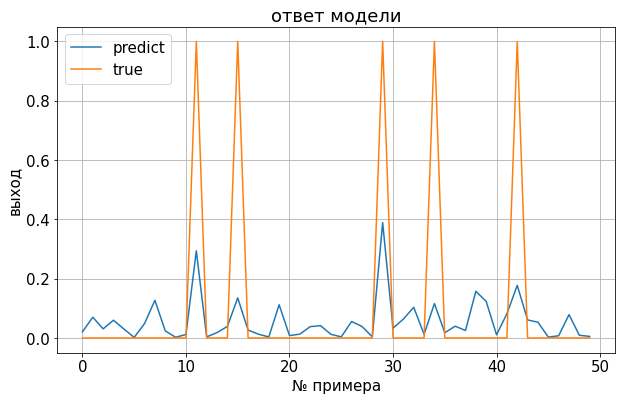

In [320]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [321]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# находим индекс наилучшего f-score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.2804823575655233, F-Score=0.779, Precision=0.733, Recall=0.832


In [322]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1682   74]
 [  42  202]]


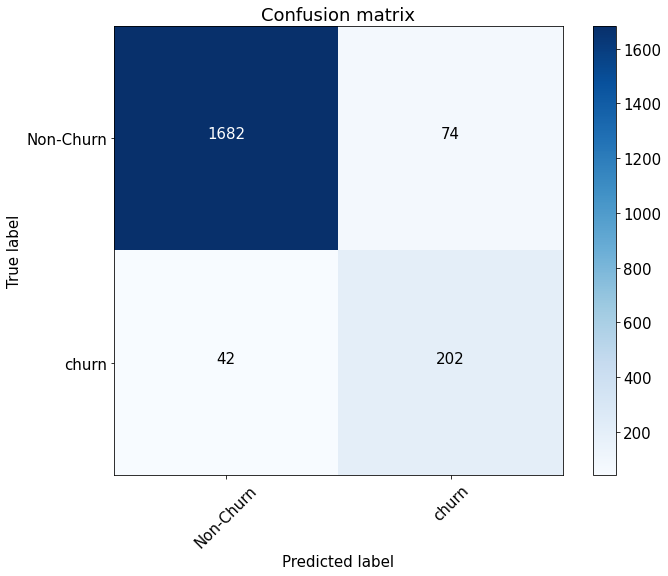

In [323]:
import itertools
font = {'size': 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                     title='Confusion matrix')

# plt.savefig('conf_matrix.png')
plt.show()

In [324]:
roc_auc_score(y_test, preds)

0.9768521976175362

In [325]:
mean_precision = precision[ix]
mean_recall = recall[ix]
mean_fscore = fscore[ix]
mean_roc_auc = roc_auc_score(y_test, preds)

# Домашнее задание

### 1. *Самостоятельно повторить tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [442]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [134]:
docs = pd.read_csv('articles.csv')

In [135]:
docs = docs['title'].progress_apply(clean_text)

100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [00:40<00:00, 666.21it/s]


In [463]:
tf = TfidfVectorizer(stop_words=stopword_ru, max_features=100)

In [464]:
tf.fit(docs)

C:\Users\ad_al\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:394: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['_ссылка', 'всё', 'интерфакс', 'как_сообщили_риа_', 'новости', 'передает_риа_', 'сообщает_', 'сообщает_риа_'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_features=100,
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

In [465]:
tf_docs = pd.DataFrame.sparse.from_spmatrix(tf.transform(docs), columns=tf.get_feature_names_out())

In [466]:
tf_docs.insert(0, 'doc_id', news['doc_id'].values)

In [467]:
tf_docs.head(3)

,doc_id,безопасности,будут,владимир,власти,вопрос,газетеru,глава,говорит,говорится,...,сша,территории,тыс,украины,ходе,частности,часть,числе,является,января
0,6,0.0,0.0,0.0,0.287383,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4896,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4897,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)

In [326]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = np.median(user_vector, axis=0)
    return user_vector

In [327]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid'] + [f'topic_{i}' for i in range(N_topic)]]

CPU times: total: 953 ms
Wall time: 985 ms


In [328]:
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.032893,0.107373,0.0,0.009807,0.0,0.195518,0.0,0.000000,0.045321,...,0.006141,0.037589,0.0,0.000000,0.011444,0.000000,0.014424,0.000000,0.005187,0.0
1,u108690,0.010891,0.042126,0.0,0.014703,0.0,0.184816,0.0,0.018483,0.114061,...,0.019303,0.183878,0.0,0.082773,0.009249,0.000000,0.012718,0.052601,0.000000,0.0
2,u108339,0.000000,0.089943,0.0,0.111164,0.0,0.153697,0.0,0.000000,0.066043,...,0.000000,0.195531,0.0,0.074800,0.046605,0.013935,0.050936,0.048742,0.000000,0.0


In [329]:
X = pd.merge(user_embeddings, target, 'left')

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                     X['churn'], random_state=2)

In [331]:
logreg = LogisticRegression()
# Обучение
logreg.fit(X_train, y_train)

LogisticRegression()

In [332]:
# Прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

Рассчитаем Precision, Recall, F-score

In [333]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# находим индекс наилучшего f-score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.24106061317196303, F-Score=0.748, Precision=0.643, Recall=0.893


In [334]:
median_precision = precision[ix]
median_recall = recall[ix]
median_fscore = fscore[ix]
median_roc_auc = roc_auc_score(y_test, preds)

### 3. Повторить п.2, но используя уже не медиану, а max

In [335]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = np.max(user_vector, axis=0)
    return user_vector

In [336]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid'] + [f'topic_{i}' for i in range(N_topic)]]

CPU times: total: 500 ms
Wall time: 498 ms


In [337]:
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.176104,0.388717,0.029888,0.214634,0.030132,0.308700,0.033672,0.176156,0.107634,...,0.355363,0.213091,0.056961,0.472323,0.132467,0.036451,0.030229,0.140973,0.069308,0.146300
1,u108690,0.051192,0.267491,0.000000,0.328808,0.026139,0.395554,0.028008,0.092781,0.154761,...,0.106723,0.471394,0.018522,0.137655,0.066724,0.015426,0.115266,0.140931,0.000000,0.042344
2,u108339,0.000000,0.190512,0.000000,0.217672,0.031592,0.184774,0.000000,0.000000,0.267297,...,0.031307,0.480103,0.012604,0.128077,0.142440,0.161767,0.167296,0.147376,0.048439,0.097971


In [338]:
X = pd.merge(user_embeddings, target, 'left')

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                     X['churn'], random_state=2)

In [340]:
logreg = LogisticRegression()
# Обучение
logreg.fit(X_train, y_train)

LogisticRegression()

In [341]:
# Прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

Рассчитаем Precision, Recall, F-score

In [342]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# находим индекс наилучшего f-score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.42103196018959543, F-Score=0.763, Precision=0.838, Recall=0.701


In [343]:
max_precision = precision[ix]
max_recall = recall[ix]
max_fscore = fscore[ix]
max_roc_auc = roc_auc_score(y_test, preds)

### 4. *Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)
 - подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал
 - подсказка 2: нужен именно idf, как вес.

In [468]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = np.mean(user_vector, axis=0)
    return user_vector

In [469]:
tf_dict = dict(zip(tf_docs['doc_id'].values, tf_docs[[i for i in tf_docs.drop(columns='doc_id').columns]].values))

In [470]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, tf_dict))])

CPU times: total: 906 ms
Wall time: 913 ms


In [471]:
user_embeddings.columns = [f'{i}' for i in tf_docs.drop(columns='doc_id').columns]

In [472]:
user_embeddings.insert(0, 'uid', users['uid'].values)

In [473]:
user_embeddings.head(3)

,uid,безопасности,будут,владимир,власти,вопрос,газетеru,глава,говорит,говорится,...,сша,территории,тыс,украины,ходе,частности,часть,числе,является,января
0,u105138,0.081954,0.000000,0.000000,0.071320,0.000000,0.021756,0.017652,0.000000,0.121265,...,0.000000,0.019558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064569,0.000000
1,u108690,0.081592,0.056324,0.016870,0.030184,0.033478,0.000000,0.056855,0.000000,0.043566,...,0.163462,0.024608,0.000000,0.227326,0.050802,0.000000,0.000000,0.027826,0.053095,0.000000
2,u108339,0.057144,0.042090,0.021251,0.125590,0.017750,0.000000,0.027245,0.018842,0.073069,...,0.087690,0.017829,0.086078,0.000000,0.021008,0.015356,0.018497,0.034342,0.070358,0.016995


In [474]:
X = pd.merge(user_embeddings, target, 'left')

In [475]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['uid', 'churn']),
                                                     X['churn'], random_state=2)

In [476]:
logreg = LogisticRegression()
# Обучение
logreg.fit(X_train, y_train)

LogisticRegression()

In [477]:
# Прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07807947, 0.01975377, 0.00815315, 0.03030988, 0.02732434,
       0.00966452, 0.00552663, 0.16707328, 0.00247549, 0.008607  ])

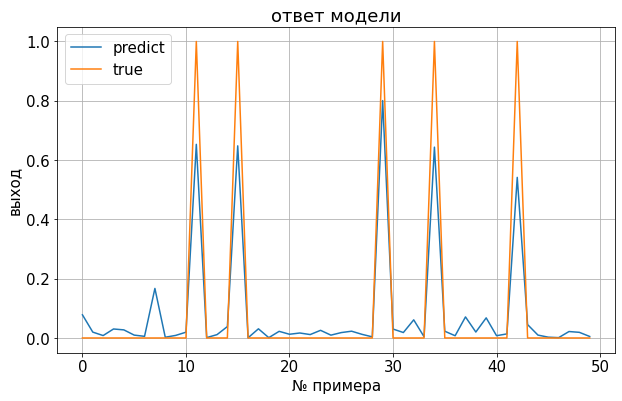

In [478]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

Рассчитаем Precision, Recall, F-score

In [479]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# находим индекс наилучшего f-score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.40443052329676055, F-Score=0.992, Precision=0.996, Recall=0.988


In [480]:
idf_precision = precision[ix]
idf_recall = recall[ix]
idf_fscore = fscore[ix]
idf_roc_auc = roc_auc_score(y_test, preds)

### 5. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [462]:
pd.DataFrame({'fscore': [mean_fscore, median_fscore, max_fscore, idf_fscore],
             'precision': [mean_precision, median_precision, max_precision, idf_precision],
             'recall': [mean_recall, median_recall, max_recall, idf_recall],
             'roc_auc_score': [mean_roc_auc, median_roc_auc, max_roc_auc, idf_roc_auc]},
             index=['mean', 'median', 'max', 'idf'])

,fscore,precision,recall,roc_auc_score
mean,0.779271,0.732852,0.831967,0.976852
median,0.747856,0.643068,0.893443,0.972063
max,0.763393,0.838235,0.700820,0.965736
idf,0.995902,0.995902,0.995902,0.999963


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных